Unfortunately, due to the problems with denoising autoencoder and the lack of space on the cluster's disk, I couldn't use the features described in the task. I chose to use MFCC features and FBANK features, both extracted by Kaldi, instead.

In [149]:
import os
import numpy as np

from features_extraction.kaldi_features import extract_mfcc, extract_fbank
from speaker_classification.lstm_classifier import SpeakerClassifier, train_model
from kaldi.util.table import SequentialMatrixReader
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
VCTK_ROOT = '/home/eshcherbin/data/VCTK-Corpus/wav48'
SEED = 117

wav_paths = []
for p in os.listdir(VCTK_ROOT):
    p_dir = os.path.join(VCTK_ROOT, p)
    for wav_file in os.listdir(p_dir):
        wav_paths.append((wav_file, os.path.join(p_dir, wav_file)))
        
train_paths, test_paths = train_test_split(wav_paths, random_state=SEED)
with open('data/train.scp', 'w') as fout:
    for k, v in train_paths:
        fout.write(f'{k} {v}\n')
with open('data/test.scp', 'w') as fout:
    for k, v in test_paths:
        fout.write(f'{k} {v}\n')

In [165]:
print('Extracting MFCC features for test')
extract_mfcc('data/test.scp', 'data/test_mfcc.ark')
print('Extracting MFCC features for train')
extract_mfcc('data/train.scp', 'data/train_mfcc.ark')
print('Extracting FBANK features for test')
extract_fbank('data/test.scp', 'data/test_fbank.ark')
print('Extracting FBANK features for train')
extract_fbank('data/train.scp', 'data/train_fbank.ark')

Extracting MFCC features for test
Extracting MFCC features for train
Extracting FBANK features for test
Extracting FBANK features for train


In [19]:
def read_features(ark_file):
    result = []
    with SequentialMatrixReader(f'ark:{ark_file}') as reader:
        for k, f in reader:
            result.append((torch.tensor(f), k[:4]))
    return result

In [22]:
train_mfcc = read_features('data/train_mfcc.ark')
test_mfcc = read_features('data/test_mfcc.ark')

In [23]:
classes = {}
for _, p in train_mfcc:
    if p not in classes:
        n_cls = len(classes)
        classes[p] = n_cls
for _, p in test_mfcc:
    if p not in classes:
        n_cls = len(classes)
        classes[p] = n_cls

In [24]:
train_mfcc = [(X, torch.tensor([classes[y]], dtype=torch.long)) for X, y in train_mfcc]
test_mfcc = [(X, torch.tensor([classes[y]], dtype=torch.long)) for X, y in test_mfcc]

In [158]:
N_MFCC = 13
N_FBANK = 23
N_HIDDEN = 50
N_EPOCHS = 100
BATCH_LEN = 1000
N_EPOCHS_TO_LOG = 10


model_mfcc = SpeakerClassifier(N_MFCC, N_HIDDEN, len(classes))
optimizer = optim.SGD(model_mfcc.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

print('Training on MFCC features')
model_mfcc, test_losses_mfcc, test_accs_mfcc = train_model(
    model_mfcc, 
    optimizer, 
    loss_fn, 
    train_mfcc, 
    test_mfcc, 
    BATCH_LEN, 
    N_EPOCHS, 
    save_path='models/model_mfcc.pth',
    seed=SEED, 
    use_cuda=torch.cuda.is_available(),
    n_epochs_to_log=N_EPOCHS_TO_LOG
)

Training on MFCC features
Epoch 9 finished in 7.574 seconds, mean train loss: 3.49332, mean test loss: 4.02030, mean test accuracy: 0.1028
Epoch 19 finished in 7.564 seconds, mean train loss: 2.32453, mean test loss: 2.19325, mean test accuracy: 0.4456
Epoch 29 finished in 7.595 seconds, mean train loss: 1.59128, mean test loss: 1.66165, mean test accuracy: 0.5663
Epoch 39 finished in 7.598 seconds, mean train loss: 1.30954, mean test loss: 1.44205, mean test accuracy: 0.6186
Epoch 49 finished in 7.577 seconds, mean train loss: 1.14227, mean test loss: 1.33560, mean test accuracy: 0.6426
Epoch 59 finished in 7.614 seconds, mean train loss: 1.03557, mean test loss: 1.26048, mean test accuracy: 0.6600
Epoch 69 finished in 7.621 seconds, mean train loss: 0.95251, mean test loss: 1.21635, mean test accuracy: 0.6729
Epoch 79 finished in 7.570 seconds, mean train loss: 0.87030, mean test loss: 1.18881, mean test accuracy: 0.6758
Epoch 89 finished in 7.616 seconds, mean train loss: 0.82481, m

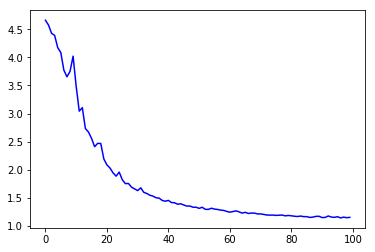

In [159]:
plt.plot(test_losses_mfcc, c='b')

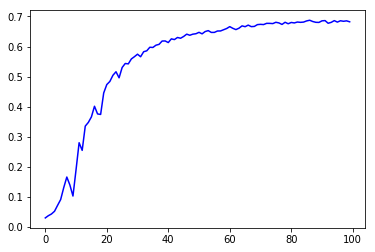

In [160]:
plt.plot(test_accs_mfcc, c='b')

In [127]:
train_fbank = read_features('data/train_fbank.ark')
test_fbank = read_features('data/test_fbank.ark')

In [128]:
train_fbank = [(X, torch.tensor([classes[y]], dtype=torch.long)) for X, y in train_fbank]
test_fbank = [(X, torch.tensor([classes[y]], dtype=torch.long)) for X, y in test_fbank]

In [161]:
N_MFCC = 13
N_FBANK = 23
N_HIDDEN = 50
N_EPOCHS = 100
BATCH_LEN = 1000
N_EPOCHS_TO_LOG = 10


model_fbank = SpeakerClassifier(N_FBANK, N_HIDDEN, len(classes))
optimizer = optim.SGD(model_fbank.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

print('Training on FBANK features')
model_fbank, test_losses_fbank, test_accs_fbank = train_model(
    model_fbank, 
    optimizer, 
    loss_fn, 
    train_fbank, 
    test_fbank, 
    BATCH_LEN, 
    N_EPOCHS, 
    save_path='models/model_fbank.pth',
    seed=SEED,
    use_cuda=torch.cuda.is_available(),
    n_epochs_to_log=N_EPOCHS_TO_LOG
)

Training on FBANK features
Epoch 9 finished in 7.618 seconds, mean train loss: 4.23145, mean test loss: 4.14557, mean test accuracy: 0.0700
Epoch 19 finished in 7.614 seconds, mean train loss: 3.66284, mean test loss: 3.51412, mean test accuracy: 0.1848
Epoch 29 finished in 7.625 seconds, mean train loss: 3.06293, mean test loss: 2.91459, mean test accuracy: 0.3026
Epoch 39 finished in 7.624 seconds, mean train loss: 2.51737, mean test loss: 2.39924, mean test accuracy: 0.4070
Epoch 49 finished in 7.642 seconds, mean train loss: 1.98082, mean test loss: 1.89729, mean test accuracy: 0.5257
Epoch 59 finished in 7.622 seconds, mean train loss: 1.57262, mean test loss: 1.61539, mean test accuracy: 0.5888
Epoch 69 finished in 7.648 seconds, mean train loss: 1.24934, mean test loss: 1.28611, mean test accuracy: 0.6661
Epoch 79 finished in 7.616 seconds, mean train loss: 1.05252, mean test loss: 1.12123, mean test accuracy: 0.6979
Epoch 89 finished in 7.613 seconds, mean train loss: 0.92086, 

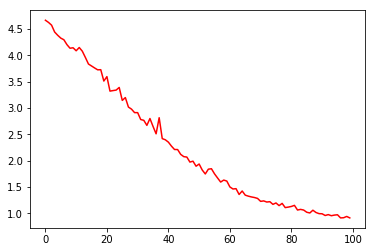

In [162]:
plt.plot(test_losses_fbank, c='r')

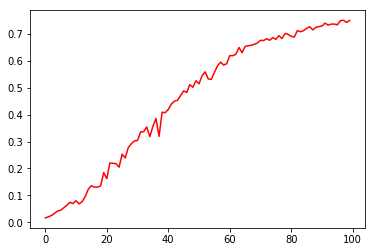

In [168]:
plt.plot(test_accs_fbank, c='r')

In [167]:
train_all = [(torch.cat((X_mfcc, X_fbank), dim=1), y)
             for (X_mfcc, y), (X_fbank, _) in zip(train_mfcc, train_fbank)]
test_all = [(torch.cat((X_mfcc, X_fbank), dim=1), y)
             for (X_mfcc, y), (X_fbank, _) in zip(test_mfcc, test_fbank)]

In [172]:
N_MFCC = 13
N_FBANK = 23
N_HIDDEN = 50
N_EPOCHS = 100
BATCH_LEN = 1000
N_EPOCHS_TO_LOG = 10

model_all = SpeakerClassifier(N_MFCC + N_FBANK, N_HIDDEN, len(classes))
optimizer = optim.SGD(model_all.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

print('Training on both MFCC and FBANK features')
model_all, test_losses_all, test_accs_all = train_model(
    model_all,
    optimizer, 
    loss_fn,
    train_all,
    test_all,
    BATCH_LEN,
    N_EPOCHS,
    save_path='models/model_all.pth',
    seed=SEED,
    use_cuda=torch.cuda.is_available(),
    n_epochs_to_log=N_EPOCHS_TO_LOG
)

Training on both MFCC and FBANK features
Epoch 9 finished in 7.848 seconds, mean train loss: 3.22055, mean test loss: 3.10304, mean test accuracy: 0.2615
Epoch 19 finished in 7.867 seconds, mean train loss: 1.93257, mean test loss: 1.84848, mean test accuracy: 0.5444
Epoch 29 finished in 7.870 seconds, mean train loss: 1.36782, mean test loss: 1.50688, mean test accuracy: 0.6129
Epoch 39 finished in 7.825 seconds, mean train loss: 1.11636, mean test loss: 1.20983, mean test accuracy: 0.6893
Epoch 49 finished in 7.849 seconds, mean train loss: 0.93096, mean test loss: 1.05219, mean test accuracy: 0.7246
Epoch 59 finished in 7.847 seconds, mean train loss: 0.77291, mean test loss: 0.97630, mean test accuracy: 0.7439
Epoch 69 finished in 7.826 seconds, mean train loss: 0.72026, mean test loss: 0.93291, mean test accuracy: 0.7513
Epoch 79 finished in 7.823 seconds, mean train loss: 0.62395, mean test loss: 0.86760, mean test accuracy: 0.7687
Epoch 89 finished in 7.873 seconds, mean train l

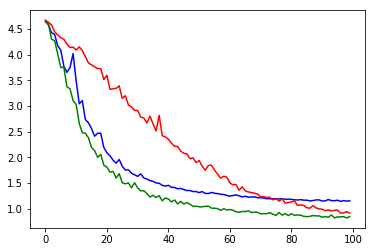

In [173]:
plt.plot(test_losses_mfcc, c='b', label='MFCC')
plt.plot(test_losses_fbank, c='r', label='FBANK')
plt.plot(test_losses_all, c='g', label='Both')

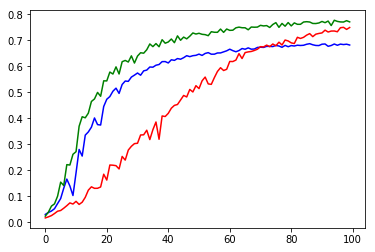

In [175]:
plt.plot(test_accs_mfcc, c='b', label='MFCC')
plt.plot(test_accs_fbank, c='r', label='FBANK')
plt.plot(test_accs_all, c='g', label='Both')

As we can see, ablation study shows that FBANK features give a bigger performance boost than than MFCC features. 